<a href="https://colab.research.google.com/github/varinen/handson-unsupervised-learning/blob/master/Chap09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semisupervised Learning

In the real world dataaset are usually partially labeled. We want to leverage information available in labeled samples and efficiently label the unlabeled ones.

Semisupervised learning uses the few available labels to uncover the data sturcture of the dataset. We will use the credit card dataset to demonstrate this ability.

We start with loading of the necessary libraries.



In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()


     |████████████████████████████████| 993kB 4.4MB/s 


In [0]:
drive = GoogleDrive(gauth)


In [4]:
link = 'https://drive.google.com/open?id=1kEH7mXyYvtduSntlTS-40XAcpSMBoFyf'
fluff, id = link.split('=')
print(id)


1kEH7mXyYvtduSntlTS-40XAcpSMBoFyf


In [5]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
data = pd.read_csv('Filename.csv')

W0620 13:52:07.787219 139675991598976 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [6]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We will create a test an a training dataset. To simulate a partially labelled, we will drop 90% of the labels in the training set.



In [0]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()


# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

# Split into train and test
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [43]:
len(X_train)

190820

In [44]:
# Drop 90% of the labels from the training set

# Out of label with value 1 (fraudulent transactions) take 90%
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)

# Remove entries that correspend to the dropped labels
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
len(X_train)

190523

Next, we reuse the functions `anomalyScores` and `plotResults` from the previous chapters.

In [0]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [0]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

We will also need a new function, `precisionAnalysis` that will measure precision at a certain recall. Specifically, we would like to measure precision at the 75% recall. The better is the precision that allows us to catch 75% of the fraud, the better is the model.

In [0]:
def precisionAnalysis(df, column, threshold):
    # sort values in the given DF by the specified column
    df.sort_values(by=column, ascending=False, inplace=True)
    
    # calculate what is the goal number of caught fraud given the threshold.
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

## Supervised Model

To benchmark our semisupervised model, we have to learn how a supervised model would perform in isolation. We will use the light gradient boosting decision tree model that perfromed the best previously. We will apply 5 fold cross-validation:

In [0]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [0]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

Let's train the algorithm:

In [51]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00397338
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00513171
[3]	valid_0's binary_logloss: 0.00603679
[4]	valid_0's binary_logloss: 0.00702635
[5]	valid_0's binary_logloss: 0.00614841
[6]	valid_0's binary_logloss: 0.00512317
[7]	valid_0's binary_logloss: 0.0123727
[8]	valid_0's binary_logloss: 0.00511973
[9]	valid_0's binary_logloss: 0.00818307
[10]	valid_0's binary_logloss: 0.00897806
[11]	valid_0's binary_logloss: 0.00866636
[12]	valid_0's binary_logloss: 0.00867258
[13]	valid_0's binary_logloss: 0.0086395
[14]	valid_0's binary_logloss: 0.00801609
[15]	valid_0's binary_logloss: 0.0074302
[16]	valid_0's binary_logloss: 0.00966375
[17]	valid_0's binary_logloss: 0.0107584
[18]	valid_0's binary_logloss: 0.00982517
[19]	valid_0's binary_logloss: 0.00960756
[20]	valid_0's binary_logloss: 0.00888414
[21]	valid_0's binary_logloss: 0.0108164
[22]	valid_0's binary_logloss: 0.0101935
[23]	valid_0's binary_loglos

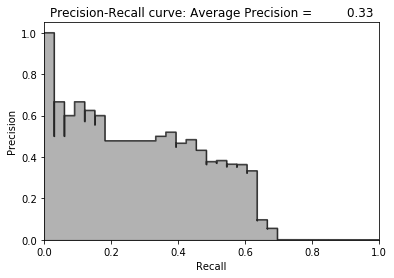

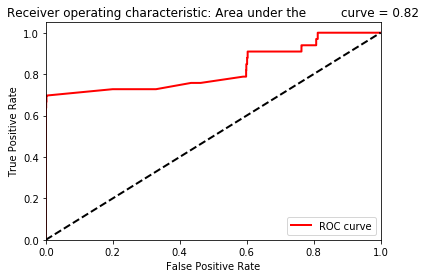

In [52]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

After the model has been trained, we use it on the test set:

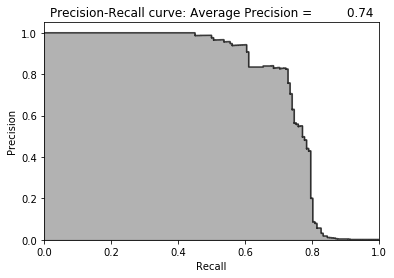

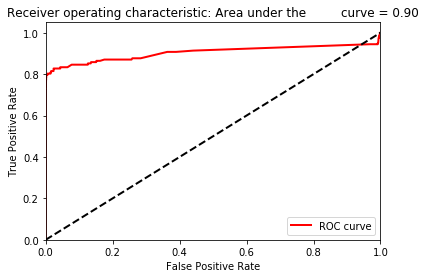

In [53]:
predictions = pd.Series(data=gbm.predict(X_test, \
                num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [54]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.5590909090909091


The average precision was 0.74. To capture 75% fraud, we have to deal with only 56% precision.

## Unsupervised Model

Now, we will see how an unsupervised model will perform. We will set up a **sparse overcomplete two-layer autoencoder** with 40 nodes in the hidden layer and 2% dropout. The activation is linear.

We also will adjust our training set by *oversampling*. We have previously dropped 90% of the fraudulent labels and have only 33 labeled fraud cases. We will duplicate these cases 100 times and add them to the training (but not test!) dataset. This will allow the autoencoder to be better trained on the few available data points.




In [0]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

Now, we can train the autoencoder:

In [0]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [0]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [58]:
num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Train on 155058 samples, validate on 38765 samples
Epoch 1/5
155058/155058 [==============================] - 7s 46us/step - loss: 0.1600 - acc: 0.8473 - val_loss: 0.1064 - val_acc: 0.9752
Epoch 2/5
155058/155058 [==============================] - 7s 44us/step - loss: 0.0558 - acc: 0.9263 - val_loss: 0.0782 - val_acc: 0.9527
Epoch 3/5
155058/155058 [==============================] - 7s 44us/step - loss: 0.0453 - acc: 0.9269 - val_loss: 0.0950 - val_acc: 0.9542
Epoch 4/5
155058/155058 [==============================] - 7s 44us/step - loss: 0.0417 - acc: 0.9259 - val_loss: 0.0428 - val_acc: 0.9741
Epoch 5/5
155058/155058 [==============================] - 7s 44us/step - loss: 0.0394 - acc: 0.9232 - val_loss: 0.3966 - val_acc: 0.9400


190523/190523 [==============================] - 3s 17us/step


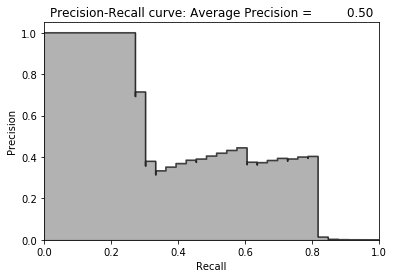

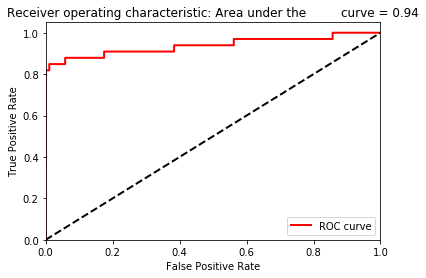

In [59]:
predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, \
                                      anomalyScoresAETrain, True)

Now, let's try the autoencoder on the test dataset:

93987/93987 [==============================] - 1s 16us/step


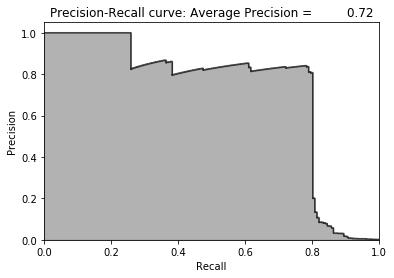

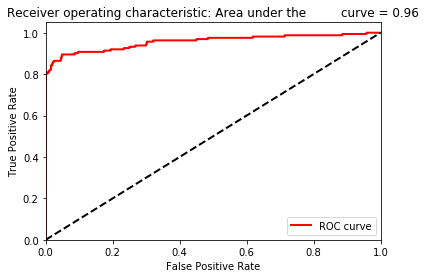

In [60]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)

In [61]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.8367346938775511


The precision as the 75% recall level delivered by the unsupervised solution is at 83%. An improvement over the supervised method.

## Semisupervised Method

For the semisupervised approach, we take the representation learned by the autoencoder (hidden layer), combine it with the original (not oversampled) training dataset and feed it into the gradient boosted algorithm.

To get the hidden layer we use the `Model` class from Keras API and its `get_layer` method:

In [0]:
layer_name = 'hidden_layer'

intermediate_layer_model = Model(inputs=model.input, \
                                 outputs=model.get_layer(layer_name).output)
intermediate_output_train = intermediate_layer_model.predict(X_train_original)
intermediate_output_test = intermediate_layer_model.predict(X_test_original)

The autoencoder inerpretations we've gotten above will be saved in DataFrames and combined with the original training and test sets.

In [0]:
intermediate_output_trainDF = \
    pd.DataFrame(data=intermediate_output_train,index=X_train_original.index)
intermediate_output_testDF = \
    pd.DataFrame(data=intermediate_output_test,index=X_test_original.index)

In [0]:
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

We now will train the gradient boosted algorithm on the data containing the original 29 features and the 40 features received from the autoencoder.

In [65]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index, \
                                        columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=5000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, 
                                gbm.predict(X_train_fold, \
                                num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
            predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', \
                        loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.00630803
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.0048083
[3]	valid_0's binary_logloss: 0.00445961
[4]	valid_0's binary_logloss: 0.00427503
[5]	valid_0's binary_logloss: 0.00417528
[6]	valid_0's binary_logloss: 0.00394639
[7]	valid_0's binary_logloss: 0.00371224
[8]	valid_0's binary_logloss: 0.00370865
[9]	valid_0's binary_logloss: 0.00370533
[10]	valid_0's binary_logloss: 0.00370148
[11]	valid_0's binary_logloss: 0.00369771
[12]	valid_0's binary_logloss: 0.00369393
[13]	valid_0's binary_logloss: 0.00369018
[14]	valid_0's binary_logloss: 0.00368647
[15]	valid_0's binary_logloss: 0.00368307
[16]	valid_0's binary_logloss: 0.00367761
[17]	valid_0's binary_logloss: 0.0036723
[18]	valid_0's binary_logloss: 0.0036685
[19]	valid_0's binary_logloss: 0.00366474
[20]	valid_0's binary_logloss: 0.00366122
[21]	valid_0's binary_logloss: 0.00365751
[22]	valid_0's binary_logloss: 0.00365407
[23]	valid_0's binary_log

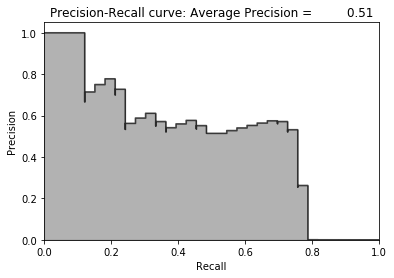

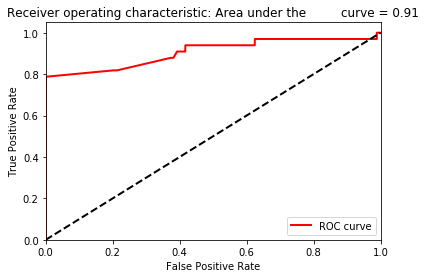

In [66]:
preds, average_precision = plotResults(y_train, \
                        predictionsBasedOnKFolds.loc[:,'prediction'], True)

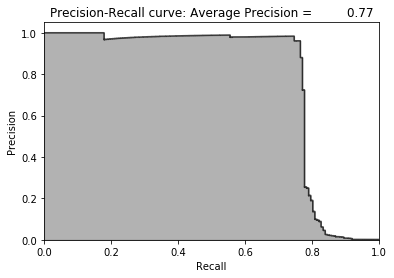

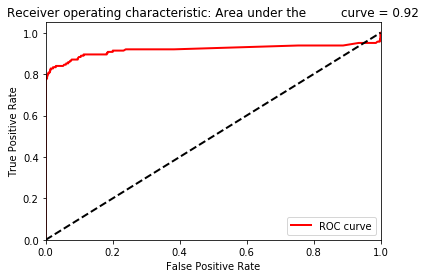

In [67]:
predictions = pd.Series(data=gbm.predict(X_test, \
                    num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [68]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print(precision)

0.9609375


Now there is a huge improvement: 96% precision at the 75% recall rate.

## The Power of Semisupervised Learning

The semisupervised solution has outdone both the supervised and unsupervised algorithms. Let's see what features were the most improtant in the semisupervised model:

In [69]:
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), \
                        index=X_train.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', \
                               ascending=False,inplace=True)
featuresImportance

,featImportance
17,0.094392
9,0.077457
Amount,0.072737
29,0.048584
32,0.038590
V15,0.037479
12,0.029706
V12,0.027207
7,0.026929
V21,0.025819


One can see, that the features delivered by the hidden layer of the autoencoder turned out to be one of the most important ones. Four out of top five features are from the hidden layer.